In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr
import netCDF4 as nc
# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colorbar import Colorbar # different way to handle colorbar
# plot styles/formatting
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# Extra 
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})
import wrf

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from xarrayMannKendall import *
from plotter import draw_basemap, make_cmap, add_subregion_boxes
from timeseries import select_months_ds


In [2]:
# Set up paths

path_to_data = '/scratch1/08540/dlnash/data/'     # project data -- read only
path_to_data = '/work2/08540/dlnash/frontera/wrf_preprocessed_data/wrf_6km/' # WORK directory
path_to_data = '/home/nash/DATA/data/wrf_hasia/' # great
path_to_out  = '../out/'                          # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'                         # figures


In [4]:
ssn = "DJF" #"MAM" or "DJF"

if ssn == 'DJF':
    start_date = '1979-12-01'
    end_date = '2015-03-31'
    mon_s = 12
    mon_e = 2
    mon_lst = [12, 1, 2]
    plt_lst = ['(a) December', '(b) January', '(c) February']
    
if ssn == 'MAM':
    start_date = '1980-03-01'
    end_date = '2014-05-31'
    mon_s = 3
    mon_e = 5
    mon_lst = [3, 4, 5]
    plt_lst = ['(a) March', '(b) April', '(c) May']

lonmin = 61.
lonmax = 98.
latmin = 22.
latmax = 56.

# subregion info for ar type precip anomalies
ext1 = [66, 74, 37, 43] # Northwestern precip anomalies
ext2 = [71, 79, 32, 37] # Western precip anomalies
ext3 = [90, 100, 24, 30] # Eastern precip anomalies
domains = [ext1, ext2, ext3]
region_name = ['NW', 'W', 'E']

# domain extent info 
# [xmin, ymin]
sr_xy = []
sr_width = []
sr_height = []

for i, d in enumerate(domains):
    sr_xy.append([d[0], d[2]])
    sr_width.append((d[1] - d[0]))
    sr_height.append((d[3]- d[2]))


### Load WRF data

In [5]:
# get terrain height from one wrf file
wrf_filename = "/work2/08540/dlnash/frontera/wrf_norris/20211113_case/wrfout_d01_2010-02-04_03:00:00"
wrf_filename = "/home/hasia/2009/wrfout_d01_2010-02-04_03:00:00"
wrfin = nc.Dataset(wrf_filename)
ter = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height

In [6]:
varname = 'zerodegisotherm'
domain = 'd01'

filename_pattern = path_to_data + '{0}/{1}/daily/out.wrf6km.{1}.daily_*.nc'.format(domain, varname)
print(filename_pattern)
ds = xr.open_mfdataset(filename_pattern)

ds

/home/nash/DATA/data/wrf_hasia/d01/zerodegisotherm/daily/out.wrf6km.zerodegisotherm.daily_*.nc


<xarray.Dataset>
Dimensions:  (time: 12906, lat: 249, lon: 259)
Coordinates:
  * time     (time) datetime64[ns] 1979-11-30 1979-12-01 ... 2015-03-31
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(32, 249, 259), meta=np.ndarray>

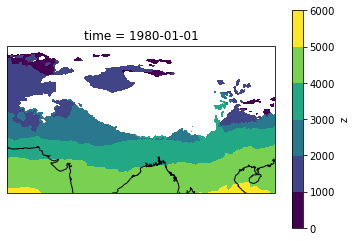

In [7]:
## test plot 1 time step of daily data
ax = plt.axes(projection=ccrs.PlateCarree())

ds.z.sel(time='1980-01-01').plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

### Average height of 0 deg isotherm during each month of winter season (climatology)

In [8]:
# get monthly climatology
ds_clim = ds.groupby("time.month").mean('time')
ds_clim

# get ssn clim
ssn_clim = ds_clim.sel(month=mon_lst).mean('month')
ssn_clim

<xarray.Dataset>
Dimensions:  (lat: 249, lon: 259)
Coordinates:
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
Data variables:
    z        (lat, lon) float32 dask.array<chunksize=(249, 259), meta=np.ndarray>

### Calculate Anomalies

In [9]:
%%time

## load filtered annual climatology
clim_mean = xr.open_dataset(path_to_data + 'd01/zerodegisotherm/filtered_daily_mean_clim_zerodegisotherm.nc')

## Calculate Anomalies
anomalies_daily = ds.groupby('time.dayofyear') - clim_mean

# resample anomalies to monthly
anomalies_mon = anomalies_daily.resample(time="1MS").mean('time')

CPU times: user 14.3 s, sys: 43.6 s, total: 57.9 s
Wall time: 59.3 s


## Trend of 0 deg isotherm over AR days

### Load AR dates and merge with daily anomalies

In [10]:
filepath = path_to_out + 'AR-types_ALLDAYS.csv'
df = pd.read_csv(filepath)

# set times as index
df = df.rename(columns={'Unnamed: 0': 'date'})
df = df.set_index(pd.to_datetime(df['date']))

# select only ssn months
if mon_s > mon_e:
    idx = (df.index.month >= mon_s) | (df.index.month <= mon_e)
if mon_s < mon_e:
    idx = (df.index.month >= mon_s) & (df.index.month <= mon_e)
df = df.loc[idx]

# normalize datetimes to 00 UTC
df.index = df.index.strftime("%Y-%m-%d")

# set to days available in WRF
idx = (df.index >= start_date) & (df.index <= end_date)
df = df.loc[idx]

# # select only ar days
idx = (df['AR_CAT'] > 0)
df = df.loc[idx]

# get list of dates that ar is present
ar_dates = pd.to_datetime(df.index).values



In [11]:
# subset non-anomalies to just ar days and calculate average
ar_daily = ds.sel(time = ar_dates)

# Combine AR Cat and ivt data w/ WRF data
colnames = ['AR_CAT']
for i, col in enumerate(colnames):
    ar_daily[col] = ('time', df[col])
    ar_daily = ar_daily.set_coords(col)
    
# subset freezing level to just ar days
anomalies_daily = anomalies_daily.sel(time = ar_dates)

# compute climatology for AR types
ar_clim = ar_daily.groupby('AR_CAT').mean('time', skipna=True).compute()
ar_std = ar_daily.groupby('AR_CAT').std('time', skipna=True).compute()

# Combine AR Cat and freeze data w/ WRF data
colnames = ['AR_CAT']
for i, col in enumerate(colnames):
    anomalies_daily[col] = ('time', df[col])
    anomalies_daily = anomalies_daily.set_coords(col)
    
anomalies_daily

/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:    (time: 1250, lat: 249, lon: 259)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2015-02-27
  * lat        (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon        (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
    dayofyear  (time) int64 335 336 342 343 350 351 355 ... 52 53 54 55 56 57 58
    AR_CAT     (time) int64 2 1 2 1 1 3 1 1 1 3 2 1 ... 2 2 2 2 2 2 1 1 3 3 3 3
Data variables:
    z          (time, lat, lon) float64 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>

In [12]:
fname = '/home/sbarc/students/nash/data/wrf_hasia/d01/zerodegisotherm_ar_clim_new.nc'
ar_clim.to_netcdf(path=fname, mode = 'w', format='NETCDF4')

fname = '/home/sbarc/students/nash/data/wrf_hasia/d01/zerodegisotherm_ar_std_new.nc'
ar_std.to_netcdf(path=fname, mode = 'w', format='NETCDF4')

### Calculate Trends

In [13]:
%%time
artype_lst = [2, 1, 3] # switch to Northwestern, Western, Eastern
final_trend_all = []
for i, ar_type in enumerate(artype_lst):
    
    # ## select only type i ARs
    idx = (anomalies_daily.AR_CAT == ar_type)
    # select AR days
    ar_ds = anomalies_daily.sel(time=idx)
    
    ### resample to seasonal average
    ar_ssn = ar_ds.resample(time="QS-DEC", skipna=True).mean()
    
    # compute trend for all months - z
    trend = compute_MK_trend_da(ar_ssn.z)
    final_trend_all.append(trend)
    

/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encou

CPU times: user 5min 33s, sys: 32.5 s, total: 6min 6s
Wall time: 5min 47s


In [14]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+5,5)
dy = np.arange(latmin,latmax+5,5)

# hack for tick labels
share_right = [False]*2 + [True]

# cmap setup
cmap = cmo.ice
clipcmap = cmocean.tools.crop_by_percent(cmap, 20, which='min', N=None)

/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


19.958362826134085 -15.730917265300192


/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


17.091234424007624 -13.473870342464297


/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


20.51868723479005 -13.9711595821229


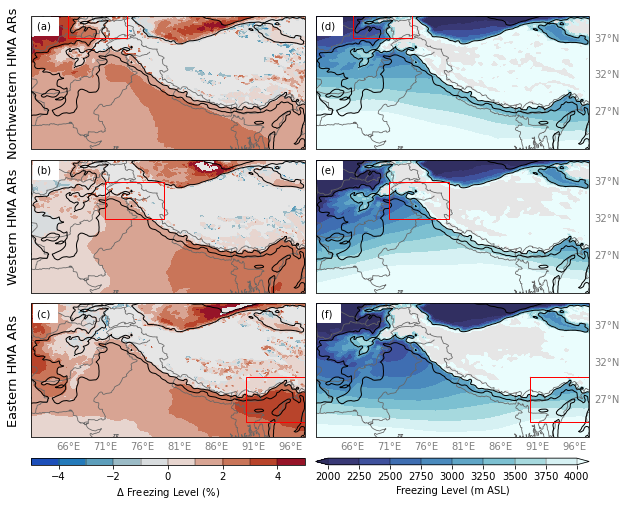

In [17]:
# hack for tick labels
share_bottom = [False]*2 + [True]

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
row_lbl = ['Northwestern HMA ARs', 'Western HMA ARs', 'Eastern HMA ARs']

# Create figure
fig = plt.figure(figsize=(10,13))
nrows = 3
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.15,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.3, cbar_size='5%',label_mode='',
                direction='column')

# Loop for drawing each plot
sr_idx = [0, 1, 2]
for k, ax in enumerate(axgr[0:nrows]):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=False, bottom_lons=share_bottom[k])
    # Data for plotting
    ds = final_trend_all[k]
    a = ds.trend
    data = a.where((a < 4) & (a > -4))
    
    lons = ds.x.values
    lats = ds.y.values
    pval_mask = ds.trend.where((ds.p <= 0.1)).values
    ssn_clim_vals = ssn_clim.z.values
    perc_change = (data*35/ssn_clim_vals)*100.
    print(np.nanmax(perc_change), np.nanmin(perc_change))

    # Contour Filled
    cflevs = np.arange(-5, 6, 1)
    clipcmap = cmocean.tools.crop_by_percent(cmo.balance, 20, which='both', N=None)
    cf = ax.contourf(lons, lats, perc_change, transform=datacrs,
                    levels=cflevs,cmap=clipcmap, extend='neither')
    
    # # Stippling Significant values
    # cs = ax.contourf(lons, lats, pval_mask, colors='none', hatches=['\\'])
    
    # Contour Lines (terrain)
    clevs=np.array([1000, 3000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)

    # Subtitles
    ttl = "({0}) ".format(letter_lst[k])
    ax.text(0.02, 0.9625, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)
    
    # add subregions
    m = sr_idx[k]
    add_subregion_boxes(ax=ax, subregion_xy=[sr_xy[m]], width=[sr_width[m]], 
                        height=[sr_height[m]], ecolor='red', datacrs=datacrs)
    # Row labels
    ax.text(-0.04, 0.5, row_lbl[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(u'$\Delta$ Freezing Level (%)', fontsize=10)
cb.ax.tick_params(labelsize=10)


# Loop for drawing each plot
arcat_lst = [2, 1, 3]
sr_idx = [0, 1, 2]
for k, ax in enumerate(axgr[nrows:]):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=True, bottom_lons=share_bottom[k])
    # Data for plotting
    data = ar_clim.sel(AR_CAT = arcat_lst[k])
    lons = data.lon.values
    lats = data.lat.values
    
    # Contour Filled
    cmap = cmo.ice
    clipcmap = cmocean.tools.crop_by_percent(cmap, 20, which='min', N=None)
    cflevs = np.arange(2000, 4250, 250)
    cf = ax.contourf(lons, lats, data.z.values, transform=datacrs,
                    levels=cflevs,cmap=clipcmap, extend='both')
    
    # Contour Lines (terrain)
    clevs=np.array([1000, 3000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    # Subtitles
    ttl = "({0}) ".format(letter_lst[k+3])
    ax.text(0.02, 0.9625, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)
    
    # add subregions
    m = sr_idx[k]
    add_subregion_boxes(ax=ax, subregion_xy=[sr_xy[m]], width=[sr_width[m]], 
                        height=[sr_height[m]], ecolor='red', datacrs=datacrs)
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True)
cb.set_label(r'Freezing Level (m ASL)', fontsize=10)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'zero_isotherm_height_AR_trend_{0}_portrait.png'.format(ssn)
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()